# The purpose of this notebook

In discussion with Michael, I mentioned that we support our use of a linear model of the suppression data by showing that it has better mean and median R^2 than a linear fit to the log-logged data. However, both box plots of fits showed a group of curves (each being one eye of one patient viewing the target under a certain surround/presentation condition etc) that were very badly fit by either model, like near zero and enough to be outliers on a boxplot. So, we thought maybe we'd remove them and see if that changes the results. That's what I'm attempting to do here; The immediately previous notebook, whose graphs are in redo-201901, are the comparison (these are in redo-2901902-exclude_bad_fits)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import string

import numpy as np
import pandas as pd
import scipy.stats as st

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

import suppression as s
import utils
import linear_model

In [4]:
pd.__version__

'0.20.3'

In [5]:
sns.__version__

'0.8.0'

In [6]:
gaba_fn = 'gaba_data.txt'
supp_fn = 'supp_data_individual_20170427.txt'

In [7]:
sdf = utils.load_psychophys(supp_fn)
gdf = utils.load_gaba(gaba_fn)

In [8]:
# Set the Population to be a categorical variable and change the names

In [9]:
#sdf.Population = sdf.Population.astype('category')
#sdf.Population.cat.categories # 0 AMB 1 CON
#sdf.Population = sdf.Population.cat.rename_categories(['Persons with Amblyopia', 'Normally-sighted individuals'])

In [10]:
#sdf['Eye'] = sdf['Eye'].astype('category')

In [11]:
gdf.Population = gdf.Population.astype('category')
gdf.Population.cat.categories # 0 AMB 1 CON
gdf.Population = gdf.Population.cat.rename_categories(['Persons with Amblyopia', 'Normally-sighted individuals'])

### Set variables used for graphing

In [12]:
colors_amb = ["#3274a1","#72b4e1"]
colors_con = ["#e1812c", "#ffc68c"]
colors4 = colors_amb + colors_con
traces4 = ['Amblyope-De', 'Amblyope-Nde', 'Control-De', 'Control-Nde']
traces_graph4 = [f"Persons with\nAmblyopia, DE", f"Persons with\nAmblyopia, NDE", \
                 f"Normally-sighted\nindividuals, DE", f"Normally-sighted\nindividuals, NDE"]
plot_dir = "plots/redo-201902-exclude_bad_fits"

## Analyze tasks separately (before subsetting to include common subjects)##

In [13]:
pp_subjs = np.unique(sdf.Subject)
n_pp_subjs = len(pp_subjs)
gaba_subjs = np.unique(gdf.subjName)
n_gaba_subjs = len(gaba_subjs)
print(f"Psychophysics subjects (n={n_pp_subjs}):\n", pp_subjs)
print(f"GABA subjects (n={n_gaba_subjs}):\n", gaba_subjs)

Psychophysics subjects (n=37):
 ['ah' 'ai' 'am' 'ap' 'bi' 'bo' 'cl' 'cr' 'ct' 'dl' 'ds' 'eg' 'ei' 'em' 'es'
 'gd' 'gm' 'gw' 'jd' 'jv' 'ke' 'kw' 'li' 'ls' 'mg' 'mk' 'ms' 'mv' 'nl' 'nn'
 'rn' 'sd' 'se' 'tj' 'tm' 'tt' 'yl']
GABA subjects (n=31):
 ['ac' 'ai' 'am' 'as' 'bi' 'ch' 'cr' 'cs' 'ct' 'dl' 'ei' 'em' 'es' 'gd' 'gm'
 'jd' 'jm' 'jv' 'ks' 'kw' 'li' 'ls' 'mg' 'mk' 'ms' 'nl' 'ps' 'rn' 'sd' 'tt'
 'yl']


# GABA only analyses

### GABA t-test, CON v AMB

In [14]:
pop_group = gdf.groupby("Population")
pop_group.describe(percentiles=[.5])

GABA                                          
                             count      mean       std    min     50%    max
Population                                                                  
Persons with Amblyopia        16.0  0.202312  0.013385  0.179  0.2025  0.227
Normally-sighted individuals  15.0  0.206333  0.016482  0.173  0.2110  0.228

In [15]:
gaba_per_group = [col for col_name, col in pop_group['GABA']]
(tstat, pval) = st.ttest_ind(*gaba_per_group)
print(tstat, pval)

-0.747810754413 0.460595837907


** Thus we find no significant difference in GABA levels between CON and AMB. **

### GABA violin plot, all subjects

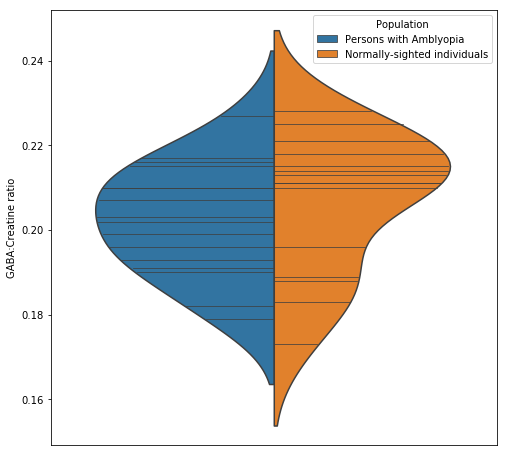

In [16]:
with s.PdfPages(f"{plot_dir}/gaba_diffs_n{n_gaba_subjs}.pdf") as pdf:
    fig = plt.figure(figsize=(8,8))  # create a figure object
    ax = fig.add_subplot(1, 1, 1)
    ax = sns.violinplot(y='GABA',x='Presentation',hue='Population',data=gdf,split=True,inner='stick',ax=ax,legend=False)
    #ax.legend_.remove()
    ax.xaxis.set_visible(False)
    ax.set_ylabel('GABA:Creatine ratio')
    #ax.set_yticklabels([])
    plt.show(ax.figure)
    pdf.savefig(ax.figure)
    plt.close(ax.figure)
    plt.close('all')

# Select one psychophysical task's data #

In [17]:
task = 'SS'
sdf = sdf[sdf['Task']==task]

In [18]:
df_to_model = sdf.copy() # make a deep copy

In [19]:
n_pp_subjs_thistask = len(np.unique(df_to_model.Subject))
amb_subjs = np.unique(df_to_model[df_to_model["Population"]=="Amblyope"]["Subject"])
print(amb_subjs)
n_amb_subjs_thistask = len(amb_subjs)
print(f"There are {n_pp_subjs_thistask} subjects for Task {task}, of which {n_amb_subjs_thistask} are Amblyopes.")

['ah' 'am' 'bi' 'cl' 'eg' 'em' 'gd' 'jv' 'li' 'mg' 'mv' 'rn' 'sd']
There are 35 subjects for Task SS, of which 13 are Amblyopes.


# Modeling

In [20]:
df_to_model.head()

,Subject,Task,Presentation,Orientation,Eye,Population,MaskContrast,ThreshElev,ThreshElev_SE,RelMaskContrast,Trace,BaselineThresh,BinCenterRelMaskContrast,BinNumber,logThreshElev,logRelMaskContrast
0,ai,SS,nMono,Iso,Nde,Control,10.0,0.615,0.009,1.449,Control-Nde,6.900,1.552,2,-0.211125,0.161068
1,ai,SS,nMono,Iso,Nde,Control,30.0,0.671,0.010,4.348,Control-Nde,6.900,3.944,4,-0.173277,0.638290
2,ai,SS,nMono,Iso,Nde,Control,62.0,1.658,0.007,8.986,Control-Nde,6.900,11.345,6,0.219585,0.953566
3,ap,SS,nMono,Iso,Nde,Control,5.0,1.277,0.007,0.961,Control-Nde,5.205,0.960,1,0.106191,-0.017277
4,ap,SS,nMono,Iso,Nde,Control,10.0,1.096,0.004,1.921,Control-Nde,5.205,1.552,2,0.039811,0.283527


### Begin grouping data into conditions to model Subject's ThreshElev as a function of logRelContrast #

In [21]:
pp_gvars = ['Task','Orientation','Presentation','Population','Subject','Eye','Trace'] # One condition
pp_gvars_base = pp_gvars + ['BaselineThresh']

In [22]:
groups_with_baseline = df_to_model.groupby(pp_gvars_base)

In [23]:
# Check if there are any conditions with only two data points
for gv, gr in groups_with_baseline:
    if len(gr)<=2:
        print(gv, gr)

#### BaselineThresh analysis before we exclude bad fits; since this is observed not modeled its ok

In [24]:
print(pp_gvars_base)
pp_gvars_base_agg = [v for v in pp_gvars if v != 'Subject']

['Task', 'Orientation', 'Presentation', 'Population', 'Subject', 'Eye', 'Trace', 'BaselineThresh']


In [25]:
pp_gvars_base_agg

['Task', 'Orientation', 'Presentation', 'Population', 'Eye', 'Trace']

In [26]:
for gv, g in df_to_model.groupby(pp_gvars_base_agg):
    print(gv, len(np.unique(g['BaselineThresh'])))

('SS', 'Cross', 'nDicho', 'Amblyope', 'De', 'Amblyope-De') 13
('SS', 'Cross', 'nDicho', 'Amblyope', 'Nde', 'Amblyope-Nde') 13
('SS', 'Cross', 'nDicho', 'Control', 'De', 'Control-De') 16
('SS', 'Cross', 'nDicho', 'Control', 'Nde', 'Control-Nde') 22
('SS', 'Cross', 'nMono', 'Amblyope', 'De', 'Amblyope-De') 13
('SS', 'Cross', 'nMono', 'Amblyope', 'Nde', 'Amblyope-Nde') 13
('SS', 'Cross', 'nMono', 'Control', 'De', 'Control-De') 16
('SS', 'Cross', 'nMono', 'Control', 'Nde', 'Control-Nde') 22
('SS', 'Iso', 'nDicho', 'Amblyope', 'De', 'Amblyope-De') 13
('SS', 'Iso', 'nDicho', 'Amblyope', 'Nde', 'Amblyope-Nde') 13
('SS', 'Iso', 'nDicho', 'Control', 'De', 'Control-De') 16
('SS', 'Iso', 'nDicho', 'Control', 'Nde', 'Control-Nde') 22
('SS', 'Iso', 'nMono', 'Amblyope', 'De', 'Amblyope-De') 13
('SS', 'Iso', 'nMono', 'Amblyope', 'Nde', 'Amblyope-Nde') 13
('SS', 'Iso', 'nMono', 'Control', 'De', 'Control-De') 16
('SS', 'Iso', 'nMono', 'Control', 'Nde', 'Control-Nde') 22


In [27]:
def test_baseline_diffs(g):
    ndes = np.unique(g[g.Eye=='Nde']['BaselineThresh'])
    des = np.unique(g[g.Eye=='De']['BaselineThresh'])
    #print(ndes, len(ndes), '\n', des, len(des))
    print(st.ttest_ind(ndes, des))

df_to_model.groupby(['Task', 'Orientation', 'Presentation', 'Population']).apply(test_baseline_diffs)

Ttest_indResult(statistic=1.5848909585669702, pvalue=0.12608067735589273)
Ttest_indResult(statistic=1.5848909585669702, pvalue=0.12608067735589273)
Ttest_indResult(statistic=-0.85047542480192784, pvalue=0.40068215248250361)
Ttest_indResult(statistic=1.5848909585669702, pvalue=0.12608067735589273)
Ttest_indResult(statistic=-0.85047542480192784, pvalue=0.40068215248250361)
Ttest_indResult(statistic=1.5848909585669702, pvalue=0.12608067735589273)
Ttest_indResult(statistic=-0.85047542480192784, pvalue=0.40068215248250361)
Ttest_indResult(statistic=1.5848909585669702, pvalue=0.12608067735589273)
Ttest_indResult(statistic=-0.85047542480192784, pvalue=0.40068215248250361)


""


In [28]:
def describe_baselines(g):
    N = len(np.unique(g['BaselineThresh']))
    baseline_mean = g['BaselineThresh'].mean()
    baseline_std = np.unique(g['BaselineThresh']).std()
    baseline_SEM = baseline_std/np.sqrt(N)
    d = {'N':N, 'mean':baseline_mean, 'std':baseline_std, 'SEM':baseline_SEM}
    return pd.Series(d)

baseline_df = df_to_model.groupby(pp_gvars_base_agg).apply(describe_baselines).reset_index()

In [29]:
baseline_df_reduced = baseline_df[(baseline_df.Orientation=='Cross') & (baseline_df.Presentation=='nMono')]

In [30]:
baseline_df_reduced

,Task,Orientation,Presentation,Population,Eye,Trace,N,SEM,mean,std
4,SS,Cross,nMono,Amblyope,De,Amblyope-De,13.0,0.341258,6.137774,1.230422
5,SS,Cross,nMono,Amblyope,Nde,Amblyope-Nde,13.0,0.629998,7.299288,2.271492
6,SS,Cross,nMono,Control,De,Control-De,16.0,0.377434,6.306926,1.509734
7,SS,Cross,nMono,Control,Nde,Control-Nde,22.0,0.297564,5.879193,1.395699


In [31]:
def get_interocular_baseline_diff(g):
    if len(g) < 2:
        return g
    else:
        assert(len(g)==2)
        nde_mean = g[g.Eye=='Nde']['mean'].iloc[0]
        de_mean = g[g.Eye=='De']['mean'].iloc[0]
        g['BaselineDiff'] = nde_mean - de_mean
        return g

def make_baseline_df_to_plot(df):
    return df.groupby('Population').apply(get_interocular_baseline_diff)

In [32]:
baseline_plot_df = make_baseline_df_to_plot(baseline_df_reduced)

In [33]:
baseline_plot_df.head()

,Task,Orientation,Presentation,Population,Eye,Trace,N,SEM,mean,std,BaselineDiff
4,SS,Cross,nMono,Amblyope,De,Amblyope-De,13.0,0.341258,6.137774,1.230422,1.161515
5,SS,Cross,nMono,Amblyope,Nde,Amblyope-Nde,13.0,0.629998,7.299288,2.271492,1.161515
6,SS,Cross,nMono,Control,De,Control-De,16.0,0.377434,6.306926,1.509734,-0.427733
7,SS,Cross,nMono,Control,Nde,Control-Nde,22.0,0.297564,5.879193,1.395699,-0.427733


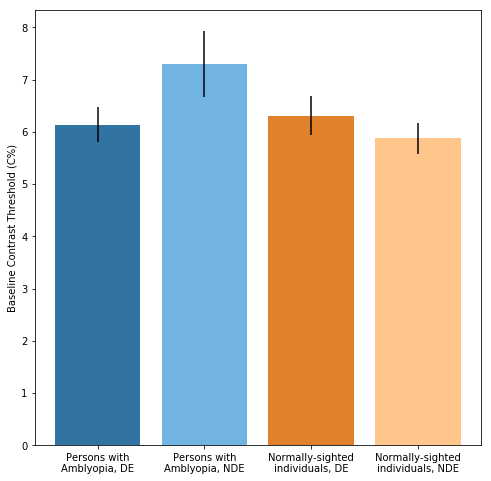

In [34]:
with s.PdfPages(f"{plot_dir}/baseline_diffs.pdf") as pdf:
    fig = plt.figure(figsize=(8,8))  # create a figure object
    ax = fig.add_subplot(1, 1, 1)
    x_pos = np.arange(len(baseline_plot_df['Trace']))
    plt.bar(x_pos, baseline_plot_df['mean'], data=baseline_plot_df, yerr='SEM', color=colors4)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(traces_graph4)
    ax.set_ylabel('Baseline Contrast Threshold (C%)')
    plt.show(ax.figure)
    pdf.savefig(ax.figure)
    plt.close(ax.figure)
    plt.close('all')
    

### Linear model (defined in linear_model.py, uses lmfit)###

In [35]:
#initialize parameters
#lm_params = linear_model.parameters()
#pfit = groups_with_baseline.apply(utils.model_threshold, linear_model.err, linear_model.thresh, lm_params, ret='weights').reset_index()
#pfit.head()

### Linear model using statsmodels

In [36]:
import statsmodels.formula.api as sm

def linear_fit(df, x, y):
    result = sm.ols(formula=f"{y} ~ {x}", data=df).fit()
    return result

def linear_fit_params(df, x, y):
    result = linear_fit(df, x, y)
    ret = result.params
    ret.index = ret.index.str.replace(x, 'slope').str.replace('Intercept','y_int')
    fit_df = ret.append(pd.Series({'rsquared':result.rsquared}))
    return fit_df

In [37]:
lin_results = groups_with_baseline.apply(linear_fit_params, 'RelMaskContrast', 'ThreshElev').reset_index()

In [38]:
lin_results.head(n=20)

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,BaselineThresh,y_int,slope,rsquared
0,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823
1,SS,Cross,nDicho,Amblyope,ah,Nde,Amblyope-Nde,4.558,1.305603,0.080449,0.638389
2,SS,Cross,nDicho,Amblyope,am,De,Amblyope-De,7.532,0.473458,0.008358,0.150669
3,SS,Cross,nDicho,Amblyope,am,Nde,Amblyope-Nde,7.834,1.035803,0.079161,0.878492
4,SS,Cross,nDicho,Amblyope,bi,De,Amblyope-De,7.827,0.859762,0.014954,0.546837
5,SS,Cross,nDicho,Amblyope,bi,Nde,Amblyope-Nde,10.141,0.712554,0.244377,0.992124
6,SS,Cross,nDicho,Amblyope,cl,De,Amblyope-De,6.709,1.021385,-0.032079,0.523622
7,SS,Cross,nDicho,Amblyope,cl,Nde,Amblyope-Nde,7.458,1.044474,0.761080,0.943153
8,SS,Cross,nDicho,Amblyope,eg,De,Amblyope-De,6.826,0.986000,0.039389,0.722331
9,SS,Cross,nDicho,Amblyope,eg,Nde,Amblyope-Nde,6.787,1.004564,0.026249,0.659700


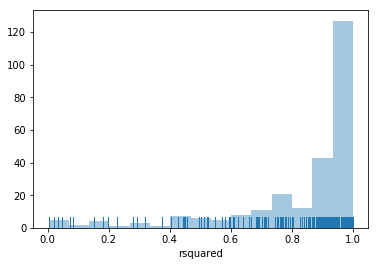

In [39]:
sns.distplot(lin_results.rsquared, kde=False, rug=True)

In [40]:
np.count_nonzero(lin_results.rsquared>.9999)

6

In [41]:
lin_results.rsquared.mean()

0.8354424459253054

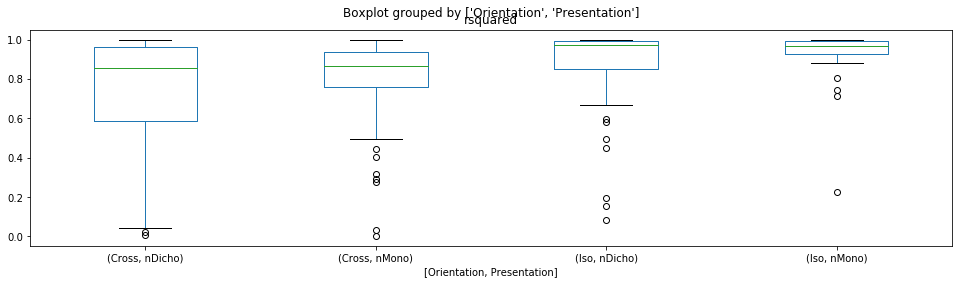

In [42]:
lin_results.boxplot(column='rsquared', by=['Orientation', 'Presentation'], grid=False, figsize=(16, 4))

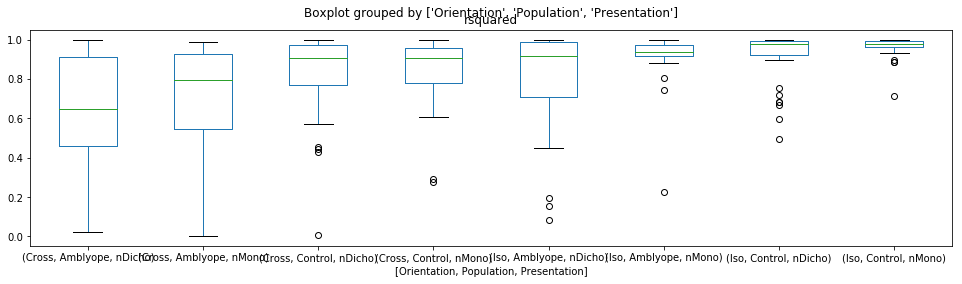

In [43]:
lin_results.boxplot(column='rsquared', by=['Orientation', 'Population', 'Presentation'], grid=False, figsize=(16, 4))

### Fit the log-logged data to see if that's better

In [44]:
log_results = groups_with_baseline.apply(linear_fit_params, 'logRelMaskContrast', 'logThreshElev').reset_index()

In [45]:
log_results.rsquared.mean()

0.7417445472530505

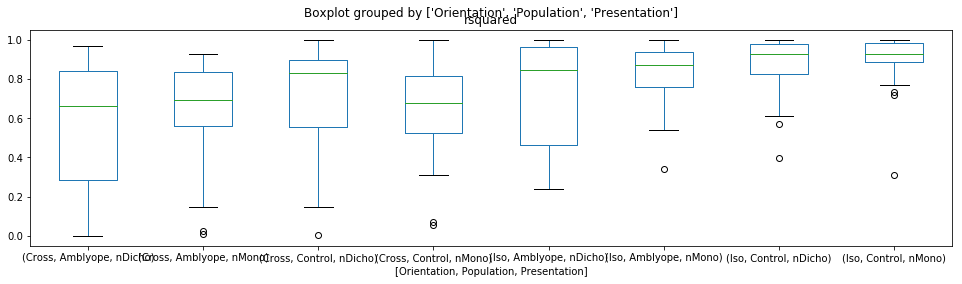

In [46]:
log_results.boxplot(column='rsquared', by=['Orientation', 'Population', 'Presentation'], grid=False, figsize=(16, 4))

## Conclusion: linear fits are overall better.

## Identify subjects with negative slope (for Jian)

In [47]:
neg_slopes = lin_results[lin_results['slope']<0]
neg_slopes

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,BaselineThresh,y_int,slope,rsquared
6,SS,Cross,nDicho,Amblyope,cl,De,Amblyope-De,6.709,1.021385,-0.032079,0.523622
12,SS,Cross,nDicho,Amblyope,gd,De,Amblyope-De,6.210,1.023065,-0.006021,0.045044
14,SS,Cross,nDicho,Amblyope,jv,De,Amblyope-De,4.227,1.689517,-0.020405,0.181212
20,SS,Cross,nDicho,Amblyope,mv,De,Amblyope-De,5.981,1.260735,-0.020939,0.503098
22,SS,Cross,nDicho,Amblyope,rn,De,Amblyope-De,6.424,0.757355,-0.017022,0.021744
24,SS,Cross,nDicho,Amblyope,sd,De,Amblyope-De,6.262,0.706531,-0.017487,0.073372
53,SS,Cross,nDicho,Control,ms,Nde,Control-Nde,4.214,0.942228,-0.004734,0.622978
78,SS,Cross,nMono,Amblyope,jv,De,Amblyope-De,4.227,1.861288,-0.038142,0.319723
86,SS,Cross,nMono,Amblyope,rn,De,Amblyope-De,6.424,0.933673,-0.033097,0.494020
132,SS,Iso,nDicho,Amblyope,bi,De,Amblyope-De,7.827,1.006648,-0.013177,0.152790


In [48]:
neg_slopes.Subject.unique()

array(['cl', 'gd', 'jv', 'mv', 'rn', 'sd', 'ms', 'bi', 'ct'], dtype=object)

## Exclude bad fits (new 2019-02-25)

In [49]:
def remove_outliers_iqr(g):
    "Remove values failing the 1.5 * IQR rule"
    q1 = g['rsquared'].quantile(.25)
    q3 = g['rsquared'].quantile(.75)
    iqr = q3 - q1
    mask = g['rsquared'].between(q1-1.5*iqr, q3+1.5*iqr, inclusive=True)
    return g.loc[mask]

def remove_outliers_halfvar(g):
    "Remove values failing the 50% variance explained (R^2 > .5) rule"
    mask = g['rsquared'].between(.5, 1, inclusive=True)
    return g.loc[mask]

In [50]:
lin_results_exc = lin_results.groupby(['Task', 'Population']).apply(remove_outliers_halfvar)

In [51]:
lin_results_exc.rsquared.min()

0.50309761635564099

In [52]:
lin_results_exc.Subject.value_counts()

ms    8
mk    8
gm    8
cl    8
cr    8
ai    8
ah    8
eg    8
se    8
tm    8
yl    8
ls    8
mv    8
nl    8
ei    7
sd    7
ct    7
es    7
kw    7
bi    7
em    7
mg    7
jd    7
dl    6
rn    6
am    6
li    6
gd    5
tj    4
ke    4
gw    4
bo    4
ap    4
nn    4
jv    3
Name: Subject, dtype: int64

In [53]:
pp_subs_exc = lin_results_exc.Subject.unique()
print(f'There are {len(pp_subs_exc)} unique subjects who have at least one condition of data.')

There are 35 unique subjects who have at least one condition of data.


## Actually use the linear model to predict thresholds

In [54]:
def linear_fit_predictions(df, x, y):
    result = linear_fit(df, x, y)
    preds = pd.Series(result.predict(), index=df[x], name='ThreshPred')
    return preds

In [55]:
lin_preds = groups_with_baseline.apply(linear_fit_predictions, 'RelMaskContrast', 'ThreshElev').reset_index()

In [56]:
lin_preds.columns

Index(['Task', 'Orientation', 'Presentation', 'Population', 'Subject', 'Eye',
       'Trace', 'BaselineThresh', 'RelMaskContrast', 'ThreshPred'],
      dtype='object')

In [57]:
lin_preds.head()

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,BaselineThresh,RelMaskContrast,ThreshPred
0,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,2.194,0.742493
1,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,3.949,0.772811
2,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,7.020,0.825863
3,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,12.286,0.916833
4,SS,Cross,nDicho,Amblyope,ah,Nde,Amblyope-Nde,4.558,1.318,1.411635


In [58]:
plot_df = pd.merge(df_to_model, lin_preds, on=pp_gvars_base + ['RelMaskContrast'])

In [59]:
plot_df.columns

Index(['Subject', 'Task', 'Presentation', 'Orientation', 'Eye', 'Population',
       'MaskContrast', 'ThreshElev', 'ThreshElev_SE', 'RelMaskContrast',
       'Trace', 'BaselineThresh', 'BinCenterRelMaskContrast', 'BinNumber',
       'logThreshElev', 'logRelMaskContrast', 'ThreshPred'],
      dtype='object')

### Plot observed values and model fits

In [60]:
s.group_facet_plots(plot_df, s.subject_fit_plot,
                    f"{plot_dir}/{task}_regressions_combinedplots_n{n_pp_subjs_thistask}_TOP.pdf",
                    ['Task','Orientation','Presentation'], #each combo of this gets its own page
                    row='Population',col='Eye',# facet rows and columns
                    x="RelMaskContrast", y="ThreshElev", # x, y
                    hue="Subject",yerr='ThreshElev_SE',fmt_obs='.',fmt_pred='x:',Ycol="ThreshPred") 

Plotting SS.Cross.nDicho
Plotting SS.Cross.nMono
Plotting SS.Iso.nDicho
Plotting SS.Iso.nMono
Plots saved at plots/redo-201902-exclude_bad_fits/SS_regressions_combinedplots_n35_TOP.pdf


In [61]:
s.group_facet_plots(plot_df, s.population_fit_plot,
                    f"{plot_dir}/{task}_regressions_combinedplots_n{n_pp_subjs_thistask}_TO.pdf",
                    ['Task','Orientation'], #each combo of this gets its own page
                    row='Presentation',col='Eye',# facet rows and columns
                    x="RelMaskContrast", y="ThreshElev", # x, y
                    hue="Population",yerr='ThreshElev_SE',fmt_obs='.',fmt_pred='x:',Ycol="ThreshPred") 

Plotting SS.Cross
Plotting SS.Iso
Plots saved at plots/redo-201902-exclude_bad_fits/SS_regressions_combinedplots_n35_TO.pdf


## Now exclude the predictions for the bad fits

In [62]:
lin_results_exc.head()

Task Orientation Presentation Population Subject  Eye  \
Task Population                                                           
SS   Amblyope   0   SS       Cross       nDicho   Amblyope      ah   De   
                1   SS       Cross       nDicho   Amblyope      ah  Nde   
                3   SS       Cross       nDicho   Amblyope      am  Nde   
                4   SS       Cross       nDicho   Amblyope      bi   De   
                5   SS       Cross       nDicho   Amblyope      bi  Nde   

                          Trace  BaselineThresh     y_int     slope  rsquared  
Task Population                                                                
SS   Amblyope   0   Amblyope-De           7.590  0.704592  0.017275  0.639823  
                1  Amblyope-Nde           4.558  1.305603  0.080449  0.638389  
                3  Amblyope-Nde           7.834  1.035803  0.079161  0.878492  
                4   Amblyope-De           7.827  0.859762  0.014954  0.546837  
                5  Amblyope-Nde          10.141  0.712554  0.244377  0.992124

In [63]:
comb_rsq_preds = pd.merge(lin_results_exc, lin_preds, on=pp_gvars_base)

In [64]:
comb_rsq_preds.rsquared.min()

0.50309761635564099

In [65]:
comb_rsq_preds.head()

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,BaselineThresh,y_int,slope,rsquared,RelMaskContrast,ThreshPred
0,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,2.194,0.742493
1,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,3.949,0.772811
2,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,7.020,0.825863
3,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,12.286,0.916833
4,SS,Cross,nDicho,Amblyope,ah,Nde,Amblyope-Nde,4.558,1.305603,0.080449,0.638389,1.318,1.411635


### Pick an xvalue (RelMaskContrast) to evaluate models at

 * 2018-09-24: Abandoning Eunice's binning. Instead, try to figure out a good RelMaskContrast programatically.
   * Just looking at it via describe(), i'd say somewhere between 5 and 10 -- probably 6 (for SS) and 10 (for OS)
 * 2018-10-08: My previous approach was too subjective. Instead, evaluate model at various percentiles...
   * do this separately for Task, Orientation, Presentation (so pick 8 total numbers)
   * At this point it's easier to just use the statsmodels.ols functions maybe? The way it's currently done is a legacy that allows different models to be swapped in... which I hope to god is not going to be the direction we go in again.
   * nvm, used the lmfit solution since it returned a nicely formatted pfit df and is tested to work
   * Here I want to take the slope and y-int and calculate the model prediction at the specified percentiles above (0-1, increments of 0.2). So, first calculate the RelMC at each of those percentiles, then apply it like below.


In [66]:
percentile_bins = np.linspace(0, 1, num=11)

In [67]:
percentile_bins

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ])

#### Get the interpolated RelMaskContrasts for each regression line, i.e. the range of x-values

In [68]:
relmc_pcts_df = comb_rsq_preds.groupby(pp_gvars_base)['RelMaskContrast'].describe(percentiles=percentile_bins)

In [69]:
# fix stupid column naming from describe()
relmc_pcts_df.columns = [f"{int(float(col[:-1])):03d}" if col[-1]=="%" else col for col in relmc_pcts_df.columns]

In [70]:
relmc_pcts_df.columns

Index(['count', 'mean', 'std', 'min', '000', '010', '020', '030', '040', '050',
       '060', '070', '080', '090', '100', 'max'],
      dtype='object')

In [71]:
relmc_pcts_df = relmc_pcts_df.filter(regex='0|1')
relmc_pcts_df.head()

000  \
Task Orientation Presentation Population Subject Eye Trace        BaselineThresh          
SS   Cross       nDicho       Amblyope   ah      De  Amblyope-De  7.590           2.194   
                                                 Nde Amblyope-Nde 4.558           1.318   
                                         am      Nde Amblyope-Nde 7.834           1.328   
                                         bi      De  Amblyope-De  7.827           0.986   
                                                 Nde Amblyope-Nde 10.141          1.278   

                                                                                     010  \
Task Orientation Presentation Population Subject Eye Trace        BaselineThresh           
SS   Cross       nDicho       Amblyope   ah      De  Amblyope-De  7.590           2.7205   
                                                 Nde Amblyope-Nde 4.558           1.6342   
                                         am      Nde Amblyope-Nde 7.834           1.7528   
                                         bi      De  Amblyope-De  7.827           1.3804   
                                                 Nde Amblyope-Nde 10.141          1.7890   

                                                                                     020  \
Task Orientation Presentation Population Subject Eye Trace        BaselineThresh           
SS   Cross       nDicho       Amblyope   ah      De  Amblyope-De  7.590           3.2470   
                                                 Nde Amblyope-Nde 4.558           1.9504   
                                         am      Nde Amblyope-Nde 7.834           2.1776   
                                         bi      De  Amblyope-De  7.827           1.7748   
                                                 Nde Amblyope-Nde 10.141          2.3000   

                                                                                     030  \
Task Orientation Presentation Population Subject Eye Trace        BaselineThresh           
SS   Cross       nDicho       Amblyope   ah      De  Amblyope-De  7.590           3.7735   
                                                 Nde Amblyope-Nde 4.558           2.2666   
                                         am      Nde Amblyope-Nde 7.834           2.7618   
                                         bi      De  Amblyope-De  7.827           2.1692   
                                                 Nde Amblyope-Nde 10.141          2.8110   

                                                                                     040  \
Task Orientation Presentation Population Subject Eye Trace        BaselineThresh           
SS   Cross       nDicho       Amblyope   ah      De  Amblyope-De  7.590           4.5632   
                                                 Nde Amblyope-Nde 4.558           2.7408   
                                         am      Nde Amblyope-Nde 7.834           3.5054   
                                         bi      De  Amblyope-De  7.827           2.5636   
                                                 Nde Amblyope-Nde 10.141          3.3220   

                                                                                     050  \
Task Orientation Presentation Population Subject Eye Trace        BaselineThresh           
SS   Cross       nDicho       Amblyope   ah      De  Amblyope-De  7.590           5.4845   
                                                 Nde Amblyope-Nde 4.558           3.2940   
                                         am      Nde Amblyope-Nde 7.834           4.2490   
                                         bi      De  Amblyope-De  7.827           2.9580   
                                                 Nde Amblyope-Nde 10.141          3.8330   

                                                                                     060  \
Task Orientation Presentation Population Subject Eye Trace        BaselineThresh           
SS   Cross       nDicho       Amblyop

In [72]:
relmc_pcts_df.columns

Index(['000', '010', '020', '030', '040', '050', '060', '070', '080', '090',
       '100'],
      dtype='object')

In [73]:
relmc_pcts_df_melted = relmc_pcts_df.reset_index().melt(id_vars=pp_gvars_base, var_name='percentile', value_name='RelMaskContrast_pct')

In [74]:
relmc_pcts_df_melted.head()

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,BaselineThresh,percentile,RelMaskContrast_pct
0,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,000,2.194
1,SS,Cross,nDicho,Amblyope,ah,Nde,Amblyope-Nde,4.558,000,1.318
2,SS,Cross,nDicho,Amblyope,am,Nde,Amblyope-Nde,7.834,000,1.328
3,SS,Cross,nDicho,Amblyope,bi,De,Amblyope-De,7.827,000,0.986
4,SS,Cross,nDicho,Amblyope,bi,Nde,Amblyope-Nde,10.141,000,1.278


In [75]:
predict_pcts_df = pd.merge(lin_results_exc, relmc_pcts_df_melted, on=pp_gvars_base)

In [76]:
predict_pcts_df.head()

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,BaselineThresh,y_int,slope,rsquared,percentile,RelMaskContrast_pct
0,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.59,0.704592,0.017275,0.639823,000,2.1940
1,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.59,0.704592,0.017275,0.639823,010,2.7205
2,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.59,0.704592,0.017275,0.639823,020,3.2470
3,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.59,0.704592,0.017275,0.639823,030,3.7735
4,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.59,0.704592,0.017275,0.639823,040,4.5632


In [77]:
predict_pcts_df['percentile'] = predict_pcts_df['percentile'].astype(int)
predict_pcts_df['RelMaskContrast_pct'] = predict_pcts_df['RelMaskContrast_pct'].astype(float)
predict_pcts_df['relmc_bin'] = (np.around(predict_pcts_df['RelMaskContrast_pct'])).astype(int)
predict_pcts_df['ThreshElev_pct'] = (predict_pcts_df['y_int'] + (predict_pcts_df['RelMaskContrast_pct']*predict_pcts_df['slope'])).astype('float')

In [78]:
predict_pcts_df.head()

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,BaselineThresh,y_int,slope,rsquared,percentile,RelMaskContrast_pct,relmc_bin,ThreshElev_pct
0,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.59,0.704592,0.017275,0.639823,0,2.1940,2,0.742493
1,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.59,0.704592,0.017275,0.639823,10,2.7205,3,0.751589
2,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.59,0.704592,0.017275,0.639823,20,3.2470,3,0.760684
3,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.59,0.704592,0.017275,0.639823,30,3.7735,4,0.769779
4,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.59,0.704592,0.017275,0.639823,40,4.5632,5,0.783421


In [79]:
predict_pcts_df.rsquared.min()

0.50309761635564099

### Plot the model fits only

In [80]:
s.group_facet_plots(predict_pcts_df, s.subject_fit_plot_pct,
                    f"{plot_dir}/{task}_regressions_pcts_n{n_pp_subjs_thistask}_TOP.pdf",
                    ['Task','Orientation','Presentation'], #each combo of this gets its own page
                    row='Population',col='Eye',# facet rows and columns
                    x="RelMaskContrast_pct", y="ThreshElev_pct", # x, y
                    hue="Subject",fmt_obs='.') 

Plotting SS.Cross.nDicho
Plotting SS.Cross.nMono
Plotting SS.Iso.nDicho
Plotting SS.Iso.nMono
Plots saved at plots/redo-201902-exclude_bad_fits/SS_regressions_pcts_n35_TOP.pdf


In [81]:
s.group_facet_plots(predict_pcts_df, s.population_fit_plot_pct,
                    f"{plot_dir}/{task}_regressions_pcts_n{n_pp_subjs_thistask}_TO.pdf",
                    ['Task','Orientation'], #each combo of this gets its own page
                    row='Presentation',col='Eye',# facet rows and columns
                    x="RelMaskContrast_pct", y="ThreshElev_pct", # x, y
                    hue="Population",fmt_obs='.') 

Plotting SS.Cross
Plotting SS.Iso
Plots saved at plots/redo-201902-exclude_bad_fits/SS_regressions_pcts_n35_TO.pdf


In [82]:
s.group_facet_plots(predict_pcts_df, s.population_fit_plot_pct,
                    f"{plot_dir}/{task}_regressions_pcts_n{n_pp_subjs_thistask}_TO_bin.pdf",
                    ['Task','Orientation'], #each combo of this gets its own page
                    row='Presentation',col='Eye',# facet rows and columns
                    x="RelMaskContrast_pct", y="ThreshElev_pct", # x, y
                    hue="relmc_bin",fmt_obs='.') 

Plotting SS.Cross
Plotting SS.Iso
Plots saved at plots/redo-201902-exclude_bad_fits/SS_regressions_pcts_n35_TO_bin.pdf


### Conclusions from these regression plots (_TO):
 * SS: looks fine, esp with new binning (IMO).
 * OS: one or two subjects really messes up the axes. One bc of a huge error bar on their observed ThreshElev, one but v low predicted ThreshElev by model; exclude? Both are controls so part of the larger group.
   * This only happens in Iso-orientation, which is different from Cross in substantial ways. What does that indicate?

In [83]:
gvars_test = ['Task','Orientation','Presentation','Population']
# equal_var=False makes it Welch's t-test, which does not assume the groups have equal variance
selected_bin_df = utils.find_pct_to_predict(predict_pcts_df, gvars_test,
                    'relmc_bin', 'ThreshElev_pct', test_func=st.ttest_ind, equal_var=False)

There are 20 bins in this condition.
10 DE obs, 21 NDE obs
p-value: 0.0015354314
10 DE obs, 21 NDE obs
p-value: 0.0015354314
13 DE obs, 28 NDE obs
p-value: 0.0001217267
10 DE obs, 17 NDE obs
p-value: 0.0026591129
8 DE obs, 14 NDE obs
p-value: 0.0073737492
8 DE obs, 12 NDE obs
p-value: 0.0344970562
4 DE obs, 13 NDE obs
p-value: 0.0082892146
2 DE obs, 8 NDE obs
p-value: 0.0336034718
3 DE obs, 4 NDE obs
p-value: 0.3643803918
3 DE obs, 5 NDE obs
p-value: 0.0423860511
1 DE obs, 4 NDE obs
p-value: nan
1 DE obs, 4 NDE obs
p-value: nan
2 DE obs, 3 NDE obs
p-value: 0.3205767408
A group with no obs, skipping
A group with no obs, skipping
1 DE obs, 2 NDE obs
p-value: nan
A group with no obs, skipping
A group with no obs, skipping
A group with no obs, skipping
A group with no obs, skipping
A group with no obs, skipping
relmc_bin 2 has lowest p-value.

There are 20 bins in this condition.
10 DE obs, 21 NDE obs
p-value: 0.0015354314
10 DE obs, 21 NDE obs
p-value: 0.0015354314
13 DE obs, 28 NDE obs
p

//anaconda/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)


relmc_bin 14 has lowest p-value.

There are 20 bins in this condition.
Not in suppression, mean of both eyes is < 1.
Not in suppression, mean of both eyes is < 1.
21 DE obs, 19 NDE obs
p-value: 0.0000100009
13 DE obs, 15 NDE obs
p-value: 0.0061183441
15 DE obs, 10 NDE obs
p-value: 0.0089245450
10 DE obs, 8 NDE obs
p-value: 0.0704511526
12 DE obs, 5 NDE obs
p-value: 0.3058439511
7 DE obs, 2 NDE obs
p-value: 0.1909077381
5 DE obs, 4 NDE obs
p-value: 0.2747719287
3 DE obs, 2 NDE obs
p-value: 0.4030222822
3 DE obs, 3 NDE obs
p-value: 0.6671644122
3 DE obs, 1 NDE obs
p-value: nan
3 DE obs, 4 NDE obs
p-value: 0.9200321286
2 DE obs, 1 NDE obs
p-value: nan
2 DE obs, 1 NDE obs
p-value: nan
1 DE obs, 2 NDE obs
p-value: nan
1 DE obs, 1 NDE obs
p-value: nan
3 DE obs, 1 NDE obs
p-value: nan
A group with no obs, skipping
A group with no obs, skipping
A group with no obs, skipping
relmc_bin 2 has lowest p-value.

There are 24 bins in this condition.
Not in suppression, mean of both eyes is < 1.
Not i

     Task Orientation Presentation Population Subject  Eye        Trace  \
1143   SS       Cross       nDicho    Control      kw  Nde  Control-Nde   
1241   SS       Cross       nDicho    Control      nn  Nde  Control-Nde   
1317   SS       Cross       nDicho    Control      yl  Nde  Control-Nde   

      BaselineThresh     y_int     slope  rsquared  percentile  \
1143           5.292  0.503865  0.089165  0.967936         100   
1241           5.741  0.990519  0.046150  0.832143          90   
1317           4.738  1.007627  0.036987  0.998511          80   

      RelMaskContrast_pct  relmc_bin  ThreshElev_pct  BinNumberToPred  
1143              14.1050         14        1.761541               14  
1241              14.2490         14        1.648108               14  
1317              13.5422         14        1.508509               14  
    Task Orientation Presentation Population Subject Eye        Trace  \
210   SS       Cross        nMono   Amblyope      ah  De  Amblyope-De   


    Task Orientation Presentation Population Subject Eye        Trace  \
672   SS         Iso        nMono   Amblyope      ah  De  Amblyope-De   
673   SS         Iso        nMono   Amblyope      ah  De  Amblyope-De   
694   SS         Iso        nMono   Amblyope      am  De  Amblyope-De   
695   SS         Iso        nMono   Amblyope      am  De  Amblyope-De   
716   SS         Iso        nMono   Amblyope      bi  De  Amblyope-De   

     BaselineThresh     y_int     slope  rsquared  percentile  \
672           7.590  0.352644  0.144725  0.959952          10   
673           7.590  0.352644  0.144725  0.959952          20   
694           7.532  0.272676  0.070505  0.914972          10   
695           7.532  0.272676  0.070505  0.914972          20   
716           7.827  0.468562  0.296027  0.999488          10   

     RelMaskContrast_pct  relmc_bin  ThreshElev_pct  BinNumberToPred  
672               1.7396          2        0.604408                2  
673               2.1612    

In [84]:
g_TOP = selected_bin_df.groupby(['Task', 'Orientation', 'Presentation'])
def set_relmctopred_to_amb_val(g):
    ambs = g[g['Population']=='Amblyope']
    assert(np.all(ambs['RelMCToPred']==ambs['RelMCToPred'].iat[0]))
    assert(np.all(ambs['BinNumberToPred']==ambs['BinNumberToPred'].iat[0]))
    g['RelMCToPred'] = ambs['RelMCToPred'].iat[0]
    g['BinNumberToPred'] = ambs['BinNumberToPred'].iat[0]
    return g
selected_bin_df = g_TOP.apply(set_relmctopred_to_amb_val).reset_index()

In [85]:
selected_bin_df.groupby(gvars_test)['RelMCToPred','ThreshElev_pct'].describe()

RelMCToPred                           \
                                               count mean  std  min  25%  50%   
Task Orientation Presentation Population                                        
SS   Cross       nDicho       Amblyope         209.0  2.0  0.0  2.0  2.0  2.0   
                              Control          374.0  2.0  0.0  2.0  2.0  2.0   
                 nMono        Amblyope         220.0  2.0  0.0  2.0  2.0  2.0   
                              Control          396.0  2.0  0.0  2.0  2.0  2.0   
     Iso         nDicho       Amblyope         242.0  2.0  0.0  2.0  2.0  2.0   
                              Control          407.0  2.0  0.0  2.0  2.0  2.0   
                 nMono        Amblyope         275.0  2.0  0.0  2.0  2.0  2.0   
                              Control          418.0  2.0  0.0  2.0  2.0  2.0   

                                                   ThreshElev_pct            \
                                          75%  max          count      mean   
Task Orientation Presentation Population                                      
SS   Cross       nDicho       Amblyope    2.0  2.0          209.0  1.405147   
                              Control     2.0  2.0          374.0  1.270859   
                 nMono        Amblyope    2.0  2.0          220.0  1.016782   
                              Control     2.0  2.0          396.0  0.967216   
     Iso         nDicho       Amblyope    2.0  2.0          242.0  1.683927   
                              Control     2.0  2.0          407.0  1.974481   
                 nMono        Amblyope    2.0  2.0          275.0  1.437772   
                              Control     2.0  2.0          418.0  1.579746   

                                                                        \
                                               std       min       25%   
Task Orientation Presentation Population                                 
SS   Cross       nDicho       Amblyope    0.625566  0.676956  1.012935   
                              Control     0.445897  0.661363  0.939387   
                 nMono        Amblyope    0.314906  0.344715  0.846435   
                              Control     0.262268  0.430126  0.795938   
     Iso         nDicho       Amblyope    1.136489  0.260012  1.023047   
                              Control     0.890109  0.474386  1.343264   
                 nMono        Amblyope    0.824721  0.366306  0.861253   
                              Control     0.938111  0.432981  0.930592   

                                                                        
                                               50%       75%       max  
Task Orientation Presentation Population                                
SS   Cross       nDicho       Amblyope    1.226023  1.565376  4.674826  
                              Control     1.184204  1.470286  3.959224  
                 nMono        Amblyope    0.999258  1.168597  2.219274  
                              Control     0.930215  1.111265  2.078230  
     Iso         nDicho       Amblyope    1.322546  2.025497  6.242498  
                              Control     1.806443  2.409358  5.881773  
                 nMono        Amblyope    1.157459  1.806846  4.903989  
                              Control     1.300831  1.972276  6.689321

In [86]:
selected_bin_df['ThreshPredCritical'] = selected_bin_df['y_int'] + selected_bin_df['slope'] * selected_bin_df['RelMCToPred']
selected_bin_df['ThreshPredCriticalUnnorm'] = selected_bin_df['ThreshPredCritical'] * selected_bin_df['BaselineThresh']

In [87]:
selected_bin_df

,index,Task,Orientation,Presentation,Population,Subject,Eye,Trace,BaselineThresh,y_int,slope,rsquared,percentile,RelMaskContrast_pct,relmc_bin,ThreshElev_pct,BinNumberToPred,RelMCToPred,ThreshPredCritical,ThreshPredCriticalUnnorm
0,0,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,0,2.1940,2,0.742493,2,2,0.739142,5.610087
1,1,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,10,2.7205,3,0.751589,2,2,0.739142,5.610087
2,2,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,20,3.2470,3,0.760684,2,2,0.739142,5.610087
3,3,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,30,3.7735,4,0.769779,2,2,0.739142,5.610087
4,4,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,40,4.5632,5,0.783421,2,2,0.739142,5.610087
5,5,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,50,5.4845,5,0.799337,2,2,0.739142,5.610087
6,6,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,60,6.4058,6,0.815252,2,2,0.739142,5.610087
7,7,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,70,7.5466,8,0.834960,2,2,0.739142,5.610087
8,8,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,80,9.1264,9,0.862251,2,2,0.739142,5.610087
9,9,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,90,10.7062,11,0.889542,2,2,0.739142,5.610087


### Melt the result of the modeling into long format for plotting

In [88]:
pfit_all_ppsub = pd.melt(selected_bin_df, id_vars=pp_gvars,
                    value_vars=['BaselineThresh', 'y_int', 'slope', 'rsquared', 'ThreshPredCritical', 'ThreshPredCriticalUnnorm'],
                    var_name='measure')
pfit_all_ppsub.head()

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,measure,value
0,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,BaselineThresh,7.59
1,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,BaselineThresh,7.59
2,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,BaselineThresh,7.59
3,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,BaselineThresh,7.59
4,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,BaselineThresh,7.59


In [89]:
pp_stats = pfit_all_ppsub[pfit_all_ppsub.measure=="ThreshPredCritical"].drop_duplicates()

In [90]:
pp_stats.groupby(['Task', 'Orientation', 'Presentation', 'Population', 'Eye', 'Trace'])['value'].describe()

count      mean  \
Task Orientation Presentation Population Eye Trace                           
SS   Cross       nDicho       Amblyope   De  Amblyope-De     6.0  0.982403   
                                         Nde Amblyope-Nde   13.0  1.261471   
                              Control    De  Control-De     14.0  0.936470   
                                         Nde Control-Nde    20.0  0.976279   
                 nMono        Amblyope   De  Amblyope-De    11.0  0.762551   
                                         Nde Amblyope-Nde    9.0  0.964448   
                              Control    De  Control-De     16.0  0.750731   
                                         Nde Control-Nde    20.0  0.788162   
     Iso         nDicho       Amblyope   De  Amblyope-De    10.0  0.901349   
                                         Nde Amblyope-Nde   12.0  1.625838   
                              Control    De  Control-De     16.0  1.122804   
                                         Nde Control-Nde    21.0  1.322261   
                 nMono        Amblyope   De  Amblyope-De    13.0  0.801333   
                                         Nde Amblyope-Nde   12.0  0.991586   
                              Control    De  Control-De     16.0  0.737310   
                                         Nde Control-Nde    22.0  0.804756   

                                                                std       min  \
Task Orientation Presentation Population Eye Trace                              
SS   Cross       nDicho       Amblyope   De  Amblyope-De   0.163032  0.739142   
                                         Nde Amblyope-Nde  0.612730  0.297554   
                              Control    De  Control-De    0.198347  0.566634   
                                         Nde Control-Nde   0.228318  0.681538   
                 nMono        Amblyope   De  Amblyope-De   0.198174  0.359336   
                                         Nde Amblyope-Nde  0.158187  0.601685   
                              Control    De  Control-De    0.143540  0.469253   
                                         Nde Control-Nde   0.148998  0.531982   
     Iso         nDicho       Amblyope   De  Amblyope-De   0.273220  0.436341   
                                         Nde Amblyope-Nde  1.140441  0.454030   
                              Control    De  Control-De    0.377191  0.180381   
                                         Nde Control-Nde   0.497474  0.675273   
                 nMono        Amblyope   De  Amblyope-De   0.227856  0.413686   
                                         Nde Amblyope-Nde  0.225432  0.606465   
                              Control    De  Control-De    0.145432  0.472317   
                                         Nde Control-Nde   0.210851  0.506221   

                                                                25%       50%  \
Task Orientation Presentation Population Eye Trace                              
SS   Cross       nDicho       Amblyope   De  Amblyope-De   0.906559  0.990985   
                                         Nde Amblyope-Nde  0.994069  1.194124   
                              Control    De  Control-De    0.805918  0.922809   
                                         Nde Control-Nde   0.753091  1.054363   
                 nMono        Amblyope   De  Amblyope-De   0.671907  0.813579   
                                         Nde Amblyope-Nde  0.897704  0.988664   
                              Control    De  Control-De    0.659041  0.729677   
                                         Nde Control-Nde   0.713164  0.795580   
     Iso         nDicho       Amblyope   De  Amblyope-De   0.738980  0.852835   
                                         Nde Amblyope-Nde  1.086408  1.290143   
                              Control    De  Control-De    0.919407  1.140042   
                                         Nde Control-Nde   0.884268  1.260197   
                 nMono        Amblyope   De  Amblyope-De   0.

In [91]:
def test_suppression_diffs(g):
    ndes = np.unique(g[g.Eye=='Nde']['value'])
    des = np.unique(g[g.Eye=='De']['value'])
    print(len(ndes), '\n', len(des))
    print(st.ttest_ind(ndes, des))

pp_stats.groupby(['Task', 'Orientation', 'Presentation', 'Population']).apply(test_suppression_diffs)

13 
 6
Ttest_indResult(statistic=1.0825104777261174, pvalue=0.29414205744888111)
13 
 6
Ttest_indResult(statistic=1.0825104777261174, pvalue=0.29414205744888111)
20 
 14
Ttest_indResult(statistic=0.52732550284357582, pvalue=0.60160479760600838)
9 
 11
Ttest_indResult(statistic=2.474989878067468, pvalue=0.023496571926463657)
20 
 16
Ttest_indResult(statistic=0.76115951680049632, pvalue=0.45180901503357873)
12 
 10
Ttest_indResult(statistic=1.9552030428234324, pvalue=0.06467814255109447)
21 
 16
Ttest_indResult(statistic=1.3360458373405841, pvalue=0.19015675677861532)
12 
 13
Ttest_indResult(statistic=2.0964030958622071, pvalue=0.04724457794997762)
22 
 16
Ttest_indResult(statistic=1.101232575038859, pvalue=0.27810416398666332)


""


## Subset to include only (GABA and psychophyics) subjects

In [92]:
gaba_and_pp_subjs = list(np.intersect1d(pp_subjs, gaba_subjs))
n_gaba_and_pp_subjs = len(gaba_and_pp_subjs)

In [93]:
sdf = sdf[sdf.Subject.isin(gaba_and_pp_subjs)] # only subjects who did _the current_ pp task and GABA
gaba_and_pp_subjs_thistask = np.unique(sdf.Subject)
n_gaba_and_pp_subjs_thistask = len(gaba_and_pp_subjs_thistask)
print(f"Of the {n_gaba_and_pp_subjs} subjects with both GABA and psychophysics data, {n_gaba_and_pp_subjs_thistask} have both for task {task}.\n{gaba_and_pp_subjs_thistask}")

Of the 24 subjects with both GABA and psychophysics data, 23 have both for task SS.
['ai' 'am' 'bi' 'cr' 'ct' 'dl' 'ei' 'em' 'es' 'gd' 'gm' 'jd' 'jv' 'kw' 'li'
 'ls' 'mg' 'mk' 'ms' 'nl' 'rn' 'sd' 'yl']


### Remove subjects we don't have data on both GABA/PP for

In [94]:
gdf = gdf[gdf.subjName.isin(sdf.Subject)] # only subjects who did both tasks
amb_subjs = (gdf[gdf.Population=='Persons with Amblyopia'])
print(f'Of the {len(gdf)} subjects with GABA and {task} data, {len(amb_subjs)} are Amblyopes.')
n_this_task = len(gdf)

Of the 23 subjects with GABA and SS data, 9 are Amblyopes.


In [95]:
stats_thistask = lin_results_exc[lin_results_exc.Subject.isin(gaba_and_pp_subjs_thistask)].groupby(['Subject'])['rsquared'].describe()

In [96]:
stats_thistask

,count,mean,std,min,25%,50%,75%,max
Subject,,,,,,,,
ai,8.0,0.935161,0.117607,0.659733,0.943784,0.986299,0.999719,0.999922
am,6.0,0.910557,0.067258,0.799772,0.887612,0.915914,0.949502,0.992865
bi,7.0,0.916000,0.164366,0.546837,0.952287,0.976332,0.992383,0.999488
cr,8.0,0.945987,0.058601,0.840411,0.904833,0.963965,0.997742,0.999292
ct,7.0,0.937913,0.077187,0.779726,0.926199,0.964989,0.985442,0.997392
dl,6.0,0.893841,0.092011,0.770530,0.821866,0.911476,0.969726,0.988424
ei,7.0,0.922415,0.140298,0.607023,0.954326,0.973990,0.983801,0.999641
em,7.0,0.885701,0.098248,0.745585,0.809151,0.921243,0.957915,0.998944
es,7.0,0.779242,0.124372,0.596832,0.697413,0.766640,0.881903,0.932588


In [97]:
n_gaba_and_pp_subjs_thistask * 8 - stats_thistask['count'].sum()

25.0

## Combine Psychophysics and GABA below

In [98]:
#Grab the GABA measure for each subject and append it to each observation for easy plotting
comb = pfit_all_ppsub.join(gdf.set_index(['subjName'])['GABA'], on=['Subject'])
comb.drop_duplicates(inplace=True)
print(len(comb))

#subset to include only those subjects with GABA data
comb_gabappsub = comb[~np.isnan(comb['GABA'])]


1386


In [99]:
comb_gabappsub.head(n=10)

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,measure,value,GABA
22,SS,Cross,nDicho,Amblyope,am,Nde,Amblyope-Nde,BaselineThresh,7.834,0.193
33,SS,Cross,nDicho,Amblyope,bi,De,Amblyope-De,BaselineThresh,7.827,0.207
44,SS,Cross,nDicho,Amblyope,bi,Nde,Amblyope-Nde,BaselineThresh,10.141,0.207
99,SS,Cross,nDicho,Amblyope,em,Nde,Amblyope-Nde,BaselineThresh,6.014,0.182
110,SS,Cross,nDicho,Amblyope,gd,Nde,Amblyope-Nde,BaselineThresh,6.536,0.203
121,SS,Cross,nDicho,Amblyope,jv,Nde,Amblyope-Nde,BaselineThresh,4.764,0.215
132,SS,Cross,nDicho,Amblyope,li,De,Amblyope-De,BaselineThresh,4.063,0.227
143,SS,Cross,nDicho,Amblyope,li,Nde,Amblyope-Nde,BaselineThresh,7.316,0.227
154,SS,Cross,nDicho,Amblyope,mg,Nde,Amblyope-Nde,BaselineThresh,5.654,0.210
187,SS,Cross,nDicho,Amblyope,rn,Nde,Amblyope-Nde,BaselineThresh,8.907,0.202


In [100]:
spearman_df = comb_gabappsub[(comb_gabappsub.measure == 'BaselineThresh') | (comb_gabappsub.measure == 'ThreshPredCritical')]

In [101]:
plot_groups = spearman_df.groupby(['Task','Orientation','Presentation','Population','measure','Eye','Trace'])
for gv, gr in plot_groups:
    #if 'nDicho' in gv:
    print(gv)
    print(stats.spearmanr(gr.GABA, gr.value))

('SS', 'Cross', 'nDicho', 'Amblyope', 'BaselineThresh', 'De', 'Amblyope-De')
SpearmanrResult(correlation=-0.99999999999999989, pvalue=nan)
('SS', 'Cross', 'nDicho', 'Amblyope', 'BaselineThresh', 'Nde', 'Amblyope-Nde')
SpearmanrResult(correlation=-0.38333333333333336, pvalue=0.30849527238037144)
('SS', 'Cross', 'nDicho', 'Amblyope', 'ThreshPredCritical', 'De', 'Amblyope-De')
SpearmanrResult(correlation=0.99999999999999989, pvalue=nan)
('SS', 'Cross', 'nDicho', 'Amblyope', 'ThreshPredCritical', 'Nde', 'Amblyope-Nde')
SpearmanrResult(correlation=-0.41666666666666663, pvalue=0.26458604674749614)
('SS', 'Cross', 'nDicho', 'Control', 'BaselineThresh', 'De', 'Control-De')
SpearmanrResult(correlation=-0.04195804195804196, pvalue=0.89698587081955417)
('SS', 'Cross', 'nDicho', 'Control', 'BaselineThresh', 'Nde', 'Control-Nde')
SpearmanrResult(correlation=-0.024518426391842117, pvalue=0.93971002232315148)
('SS', 'Cross', 'nDicho', 'Control', 'ThreshPredCritical', 'De', 'Control-De')
SpearmanrResu

In [102]:
#graphs!
colors_a = ["#3274a1","#72b4e1"]
colors_c = ["#e1812c", "#ffc68c"]
with s.PdfPages(f"{plot_dir}/gaba_vs_{task}_n{n_this_task}_linear.pdf") as pdf:
    plot_groups = spearman_df.groupby(['Task','Orientation','Presentation','Population','measure'])
    for gv, gr in plot_groups:
        #if gv[2] == 'nDicho':
        print(gv, np.all(np.isnan(gr['value'])), len(gr['value']))
        pal = [colors_a if gv[-2] in ['Amblyope'] else colors_c]
        g2 = s.gaba_vs_psychophys_plot_2line_nofacet(gv, gr, palette=pal[0], aspect=1.2)
        pdf.savefig(g2.fig)

plt.close('all')

('SS', 'Cross', 'nDicho', 'Amblyope', 'BaselineThresh') False 11
('SS', 'Cross', 'nDicho', 'Amblyope', 'ThreshPredCritical') False 11
('SS', 'Cross', 'nDicho', 'Control', 'BaselineThresh') False 24
('SS', 'Cross', 'nDicho', 'Control', 'ThreshPredCritical') False 24
('SS', 'Cross', 'nMono', 'Amblyope', 'BaselineThresh') False 12
('SS', 'Cross', 'nMono', 'Amblyope', 'ThreshPredCritical') False 12
('SS', 'Cross', 'nMono', 'Control', 'BaselineThresh') False 26
('SS', 'Cross', 'nMono', 'Control', 'ThreshPredCritical') False 26
('SS', 'Iso', 'nDicho', 'Amblyope', 'BaselineThresh') False 14
('SS', 'Iso', 'nDicho', 'Amblyope', 'ThreshPredCritical') False 14
('SS', 'Iso', 'nDicho', 'Control', 'BaselineThresh') False 27
('SS', 'Iso', 'nDicho', 'Control', 'ThreshPredCritical') False 27
('SS', 'Iso', 'nMono', 'Amblyope', 'BaselineThresh') False 17
('SS', 'Iso', 'nMono', 'Amblyope', 'ThreshPredCritical') False 17
('SS', 'Iso', 'nMono', 'Control', 'BaselineThresh') False 28
('SS', 'Iso', 'nMono', 'C

In [103]:
comb_gabappsub.head()

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,measure,value,GABA
22,SS,Cross,nDicho,Amblyope,am,Nde,Amblyope-Nde,BaselineThresh,7.834,0.193
33,SS,Cross,nDicho,Amblyope,bi,De,Amblyope-De,BaselineThresh,7.827,0.207
44,SS,Cross,nDicho,Amblyope,bi,Nde,Amblyope-Nde,BaselineThresh,10.141,0.207
99,SS,Cross,nDicho,Amblyope,em,Nde,Amblyope-Nde,BaselineThresh,6.014,0.182
110,SS,Cross,nDicho,Amblyope,gd,Nde,Amblyope-Nde,BaselineThresh,6.536,0.203


In [104]:
spearman_df.head()

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,measure,value,GABA
22,SS,Cross,nDicho,Amblyope,am,Nde,Amblyope-Nde,BaselineThresh,7.834,0.193
33,SS,Cross,nDicho,Amblyope,bi,De,Amblyope-De,BaselineThresh,7.827,0.207
44,SS,Cross,nDicho,Amblyope,bi,Nde,Amblyope-Nde,BaselineThresh,10.141,0.207
99,SS,Cross,nDicho,Amblyope,em,Nde,Amblyope-Nde,BaselineThresh,6.014,0.182
110,SS,Cross,nDicho,Amblyope,gd,Nde,Amblyope-Nde,BaselineThresh,6.536,0.203


In [117]:
# Alternate graphs, from fit no bins, using faceting func
#graphs!
with s.PdfPages(f"{plot_dir}/gaba_vs_{task}_n{n_this_task}_facet.pdf") as pdf:
    temp_df = spearman_df.copy()
    temp_df['Eye'] = temp_df['Eye'].astype('category')
    plot_groups = temp_df.groupby(['Task','Orientation','Population','measure'])
    for gv, gr in plot_groups:
        if "BaselineThresh" in gv: continue
        if "Amblyope" in gv:
            pal = colors_a
        elif "Control" in gv:
            pal = colors_c
        else:
            print('Error! neither amb nor con!')
        print(gv, np.all(np.isnan(gr['value'])))
        g2 = s.gaba_vs_psychophys_plot_2line(gv, gr, palette=pal)
        pdf.savefig(g2.fig)
        
    plt.close('all')

('SS', 'Cross', 'Amblyope', 'ThreshPredCritical') False
('SS', 'Cross', 'Control', 'ThreshPredCritical') False
('SS', 'Iso', 'Amblyope', 'ThreshPredCritical') False
('SS', 'Iso', 'Control', 'ThreshPredCritical') False


### Conclusions from the graphs we just generated
#### The conclusions below are a couple iterations old but should still be true
#### SS, but using old bins initially; updated with new bins info:
 * BaselineThresh
    * There is a negative relationship between GABA and BaselineThresh for both eyes, both populations, both surround conditions. This is an interesting finding in itself...
      * (nDicho and nMono are identical since this is baseline thresh, ie just one eye)
      * new bins: this remains true.
 * DepthOfSuppression
    * In SS/Cross/Dicho, more GABA = less suppression of NDE, but = more suppression of DE. This is especially true of Amblyopes, while in Controls the effect is weak/insignificant.
      * new bins: this remains true, and the positive slope of GABA vs suppression for the DE is higher in nMono than nDicho -- what does this mean?
    * In SS/Iso/Dicho, more GABA = less suppression of NDE, = more suppression of DE. Effect is very strong for Amblyopes and absent for other conditions(AMB/Mono and all Controls)
      * new bins: still true
 * Critical Bin Center (RelMCToPred)
    * In SS/Cross/Dicho the NDE has a higher (numerically, in multiples of baseline) RelMCToPred for both AMB and CON
    * But in SS/Cross/Mono it's the reverse, DE has higher RelMCToPred for both populations
    * new bins: this measure is rendered obsolete since I handpicked an x-val
 * ThreshPredCritical
    * For both Cross and Iso, Dicho/AMB shows biggest difference b/t NDE and DE in predicted threshold elevation. Other conditions show little to no difference.
    * new bins: now seeing this effect in AMB/nMono, similar to DepthofSuppression
 * ThreshPredCriticalUnnorm
    * When we normalize by each eye's baseline, this effect is still present.
    * new bins: still true, and unlike baseline-normalized ThreshPredCritical, effect not present in nMono (ie same pattern as with the old bins)
 * Linear model slope
    * AMB/Dicho shows biggest difference between trends in each eye for both presentation conditions. more GABA ~ lower slope of the line for NDE, while DE is basically flat.
    * new bins: nMono shows effect too, AMB look v different than controls, esp in Dicho.
 * Linear model y-int
    * AMB/Dicho has opposite GABA vs y-int slopes for both Iso and Cross, but the distributions overlap for all conditions and populations, so this is a weak finding.
    * new bins: same
    
#### OS, new bins
 * BaselineThresh
   * no strong trends vs GABA for either Iso or Cross.
 * DepthOfSuppression
   * Cross: positive slope for NDE in all conditions, much stronger in Dicho. DE flat in all, p much.
   * Iso: negative slope for NDE in AMB/Dicho. Positive/flat slopes in other conditions, and for De slopes 
 * Critical Bin Center (RelMCToPred): handpicked
 * ThreshPredCritical
   * Cross: NDE positive, DE flat-ish, least CI overlap in AMB/Dicho
   * Iso: everything overlaps a lot. least so in AMB/Dicho (NDE vs DE)
 * ThreshPredCriticalUnnorm
   * Cross: Same as normalized, but bigger diff/less overlap in AMB/Dicho than normalized.
   * Iso: everything overlaps a lot. least so in AMB/Dicho
 * Linear model slope
   * Cross: basically all flat, except nMono/AMB/NDE? Weak/nonexistent/CI overlappy tho.
   * Iso: Trending opposite DE/NDE but all overlap a lot
 * Linear model y-int
   * Cross: NDE slopes positive (for both AMB and CON, but higher magnitude for AMB), least overlap in AMB/Dicho
   * NDE vs DE trend similar in Dicho but opposite in Mono (for both Con and AMB), but lots of overlap


### Combine measures across the two eyes

 * Does it make sense to combine all measures across both eyes (i.e. by subtracting?) For example, ThreshElev is in units of baseline, and the baseline varies by eye. So perhaps only a few measures should be combined -- say, slope/yint, ThreshPredCriticalUnnorm. 

In [106]:
measures = comb_gabappsub[comb_gabappsub["measure"].isin(["BaselineThresh","ThreshPredCritical"])]

In [107]:
np.unique(measures.measure)

array(['BaselineThresh', 'ThreshPredCritical'], dtype=object)

In [108]:
paired_obs = measures.groupby(['Task', 'Orientation', 'Population', 'Presentation', 'Subject', 'measure'])

def get_eyediff_value(g):
    if len(g)==2: # this will exclude paired observations where there was no data for one eye
        value_diff = g[g['Eye']=='Nde'].value.iat[0] - g[g['Eye']=='De'].value.iat[0]
        #print(g.name, value_diff)
        return pd.Series([value_diff], ['Nde-De'])
    else:
        print(f"Skipping because one eye is missing...")

In [109]:
obs_diff = paired_obs.apply(get_eyediff_value).reset_index()

Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye 

In [110]:
obs_diff[obs_diff.Subject=='em']

,Task,Orientation,Population,Presentation,Subject,measure,Nde-De
4,SS,Cross,Amblyope,nDicho,em,BaselineThresh,NaN
5,SS,Cross,Amblyope,nDicho,em,ThreshPredCritical,NaN
22,SS,Cross,Amblyope,nMono,em,BaselineThresh,0.065000
23,SS,Cross,Amblyope,nMono,em,ThreshPredCritical,0.370533
94,SS,Iso,Amblyope,nDicho,em,BaselineThresh,0.065000
95,SS,Iso,Amblyope,nDicho,em,ThreshPredCritical,1.362006
112,SS,Iso,Amblyope,nMono,em,BaselineThresh,0.065000
113,SS,Iso,Amblyope,nMono,em,ThreshPredCritical,0.369893


In [111]:
comb_botheyes = obs_diff.join(gdf.set_index(['subjName'])['GABA'], on=['Subject'])

In [118]:
comb_botheyes

,Task,Orientation,Population,Presentation,Subject,measure,Nde-De,GABA
0,SS,Cross,Amblyope,nDicho,am,BaselineThresh,NaN,0.193
1,SS,Cross,Amblyope,nDicho,am,ThreshPredCritical,NaN,0.193
2,SS,Cross,Amblyope,nDicho,bi,BaselineThresh,2.314000,0.207
3,SS,Cross,Amblyope,nDicho,bi,ThreshPredCritical,0.311639,0.207
4,SS,Cross,Amblyope,nDicho,em,BaselineThresh,NaN,0.182
5,SS,Cross,Amblyope,nDicho,em,ThreshPredCritical,NaN,0.182
6,SS,Cross,Amblyope,nDicho,gd,BaselineThresh,NaN,0.203
7,SS,Cross,Amblyope,nDicho,gd,ThreshPredCritical,NaN,0.203
8,SS,Cross,Amblyope,nDicho,jv,BaselineThresh,NaN,0.215
9,SS,Cross,Amblyope,nDicho,jv,ThreshPredCritical,NaN,0.215


In [113]:
print(len(np.unique(comb_botheyes.Subject)))

23


In [114]:
test_groups = comb_botheyes.groupby(['Task','Orientation','Presentation','Population','measure'])
for gv, gr in test_groups:
    #print(gr.head())
    if gv[-1]=="ThreshPredCritical":
        print(gv)
        print(stats.spearmanr(gr.GABA, gr['Nde-De']))

('SS', 'Cross', 'nDicho', 'Amblyope', 'ThreshPredCritical')
SpearmanrResult(correlation=nan, pvalue=nan)
('SS', 'Cross', 'nDicho', 'Control', 'ThreshPredCritical')
SpearmanrResult(correlation=nan, pvalue=nan)
('SS', 'Cross', 'nMono', 'Amblyope', 'ThreshPredCritical')
SpearmanrResult(correlation=nan, pvalue=nan)
('SS', 'Cross', 'nMono', 'Control', 'ThreshPredCritical')
SpearmanrResult(correlation=nan, pvalue=nan)
('SS', 'Iso', 'nDicho', 'Amblyope', 'ThreshPredCritical')
SpearmanrResult(correlation=nan, pvalue=nan)
('SS', 'Iso', 'nDicho', 'Control', 'ThreshPredCritical')
SpearmanrResult(correlation=nan, pvalue=nan)
('SS', 'Iso', 'nMono', 'Amblyope', 'ThreshPredCritical')
SpearmanrResult(correlation=nan, pvalue=nan)
('SS', 'Iso', 'nMono', 'Control', 'ThreshPredCritical')
SpearmanrResult(correlation=0.094609518196319908, pvalue=0.74766903154036646)


In [115]:
#graphs!
with s.PdfPages(f"{plot_dir}/gaba_vs_{task}_combeyes_n{n_this_task}.pdf") as pdf:
    plot_groups = comb_botheyes.groupby(['Task','Orientation','measure'])
    for gv, gr in plot_groups:
        print(gv)
        g2 = s.gaba_vs_psychophys_plot_2line_2eye(gv, gr)
        pdf.savefig(g2.fig)
        
    plt.close('all')

('SS', 'Cross', 'BaselineThresh')
('SS', 'Cross', 'ThreshPredCritical')
('SS', 'Iso', 'BaselineThresh')
('SS', 'Iso', 'ThreshPredCritical')


In [116]:
# more graphs for presentation!
with s.PdfPages(f"{plot_dir}/gaba_vs_{task}_combeyes_n{n_this_task}_poster.pdf") as pdf:
    plot_groups = comb_botheyes.groupby(['Task','Orientation','Presentation','measure'])
    for gv, gr in plot_groups:
        if gv[-2] in ["nDicho"]: # use this line to exclude measures we don't want
            print(gv)
            g2 = s.gaba_vs_psychophys_plot_2line_2eye_nofacet(gv, gr, hue="Population", size=5, aspect=1.2, legend=False)
            #print(g2.axes)
            pdf.savefig(g2.fig)
        
    plt.close('all')

('SS', 'Cross', 'nDicho', 'BaselineThresh')
('SS', 'Cross', 'nDicho', 'ThreshPredCritical')
('SS', 'Iso', 'nDicho', 'BaselineThresh')
('SS', 'Iso', 'nDicho', 'ThreshPredCritical')


### Conclusions from Interocular suppression graphs
#### SS, new bins
 * Interocular difference measures all seem to get back to “the two eyes of amblyopes are more different than the two eyes of controls, and the magnitude of this difference is inversely related to GABA).
   * This is interesting and we want to present it, right?

#### OS, new bins:
 * Some strong effects in y-int Iso in both Dicho and esp. Mono. Cross is a wash
 * Other measures look fairly similar?